Assignment:
    
AI Travel Agent & Expense Planner(Purpose: Trip planning for any city worldwide with Realtime data.")

• Real-time weather information
• Top attractions and activities
• Hotel cost calculation (per day × total days)
• Currency conversion to user's native currency
• Complete itinerary generation
• Total expense calculation
• generate a summary of the entire output

user_input
  |
search attraction and activity
1. search attracation
2. search restaurant
3. search activity
4. search transportation
  |
search weather forcasting
1. get current weather
2. get weather forcast
  |
search hotel costs
1. search hotel
2. estimate the hotel cost
3. budget_range
  |
calculate total cost
1. add
2. multiply
3. calculated total cost
4. calcualte the daily budget
    | 
currency_converion
1. get exchnage rate
2. convert currancy
    | 
Itinery generation
1. get day plan
2. crete full itinery
    |
create Trip Summary
    |
Retun complete traval plan

Note: if you know the OOPS then design this entire system using object and class in modular fashion

In [1]:
# load env
from dotenv import load_dotenv
import os
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["PINECODE_API_KEY"]=os.getenv("PINECODE_API_KEY")
os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")
os.environ["HUGGINGFACE_API_KEY"]=os.getenv("HUGGINGFACE_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]=os.getenv("LANGCHAIN_TRACING_V2")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["WEATHER_API_KEY"]=os.getenv("WEATHER_API_KEY")
os.environ["SERPER_API_KEY"]=os.getenv("SERPER_API_KEY")
os.environ["EXCHANGE_RATE_API"]=os.getenv("EXCHANGE_RATE_API")

In [2]:
# load llm model
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o", temperature=0)

In [3]:
#search attraction and activity
#1. search attraction
#2. search restaurant
#3. search activity
#4. search transportation
from langchain_core.tools import tool
from langchain_tavily import TavilySearch

@tool
def search_attractions(city: str) -> str:
    """
    Search top tourist attractions in a given city.

    Args:
        city (str): Name of the city to search for tourist attractions.

    Returns:
        str: A list of top tourist attractions or places of interest.
    """
    tavily = TavilySearch(max_results=5)
    return tavily.invoke(f"top tourist attractions in {city}")

search_attractions("dhaka")

@tool
def search_restaurants(city: str) -> str:
    """
    Search the best restaurants in a given city.

    Args:
        city (str): Name of the city to search for restaurants.

    Returns:
        str: A list of popular restaurants to try.
    """
    tavily = TavilySearch(max_results=5)
    return tavily.run(f"best restaurants to try in {city}")


@tool
def search_activities(city: str) -> str:
    """
    Search top activities or things to do in a city.

    Args:
        city (str): Name of the city to search for fun activities.

    Returns:
        str: A list of popular activities or experiences in the city.
    """
    tavily = TavilySearch(max_results=5)
    return tavily.run(f"fun activities to do in {city}")

@tool
def search_transportation(city: str) -> str:
    """
    Search transportation options in a city.

    Args:
        city (str): Name of the city to search for transport details.

    Returns:
        str: Transportation options like bus, metro, taxi, and car rental.
    """
    
    tavily = TavilySearch(max_results=5)
    return tavily.run(f"list of transportation options in {city} for tourists")



/var/folders/r6/94rtxyj11sgb8st7ytmz40ph0000gn/T/ipykernel_14361/2160629848.py:23: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  search_attractions("dhaka")


In [4]:
search_attractions.invoke("delhi")


{'query': 'top tourist attractions in delhi',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': '52 Best Places to visit in Delhi | Top Tourist Attractions | 2025',
   'url': 'https://www.holidify.com/places/delhi/sightseeing-and-things-to-do.html',
   'content': 'Delhi Travel Packages Splendid Delhi Agra Jaipur Package Top Hotels In Delhi Water Parks In Delhi Delhi Zoo National Museum, Delhi Rail Museum, Delhi Shopping in Delhi What are the best street food places in Delhi? How much does a package cost for Delhi? What are the top sightseeing places in Delhi? What are the top shopping places in Delhi? Delhi Package Collections Delhi Honeymoon Packages Delhi Agra Jaipur Tour Package 4 Days Delhi Agra Rajasthan Tour Package with Boat Ride on Lake Pichola Delhi Sightseeing Tour Package: Agra & Ranthambhore National Park Delhi Agra Mathura Tour Package: India Golden Triangle Tour Delhi Agra Tour Package 3 Days -  Excursion to Rishikesh & Haridwar Delhi Ag

In [5]:
search_activities.invoke("delhi")


{'query': 'fun activities to do in delhi',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': '41 Fun Places in Delhi to Visit Right Now - Suzanne Wanders Delhi',
   'url': 'https://suzannewandersdelhi.com/fun-places-in-delhi/',
   'content': "Delhi is a great mix of historic sites, fun activities, and eclectic neigbourhoods. There's something for everyone. Here are the most fun places in Delhi: 1. India Gate ... The sound and light show Jai Hind is one of the most fun things to do in Delhi. It's a dynamic show with live performers, puppets, state of the art sound and visual",
   'score': 0.9053309,
   'raw_content': None},
  {'title': '39 Fun Places To Visit In Delhi With Friends & Family In 2025',
   'url': 'https://traveltriangle.com/blog/fun-places-in-delhi/',
   'content': '*   [**List of 39 Places To Visit In Delhi With Friends**](https://traveltriangle.com/blog/fun-places-in-delhi/#1_1) Book Cafes – Haven For Bookworms](https://traveltriangle.co

In [6]:
search_restaurants.invoke("delhi")

{'query': 'best restaurants to try in delhi',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'The 12 best restaurants in Delhi - Time Out',
   'url': 'https://www.timeout.com/delhi/restaurants/best-restaurants-in-delhi',
   'content': 'From traditional eateries to hidden gems, the best restaurants in Delhi make a compelling case Sunday 6 November 2022 Share Copy Link FacebookTwitterPinterestEmailWhatsApp Written by Anum Mulla Advertising Delhi is a bustling metropolis, and the best way to grab hold of the city is by stuffing your face with all the food you can. The best restaurants in Delhi showcase a city at its best, shimmering with variety and ingredients from all over. The Indian capital is thrillingly multicultural, and quality food is everywhere, from high-level fine-dining restaurants to lick-your-fingers street stands. Bukhara Photograph: Courtesy Tripadvisor/Gaelleloe Bukhara proves to be, without a doubt, the mother of all authentic India

In [7]:

search_transportation.invoke("delhi")

{'query': 'list of transportation options in delhi for tourists',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': '5 Common Transportation Options in Delhi, India',
   'url': 'https://www.thesavvyglobetrotter.com/common-transportation-options-delhi-india/',
   'content': 'The Delhi Metro is an intra-city rail network with at least six lines offering transportation. If you plan on being in Delhi for an extended period, you can purchase a smart card for discounts. Alternatively, you can buy a tourist card that offers unlimited travel for two to three days. Rickshaws',
   'score': 0.8700796,
   'raw_content': None},
  {'title': 'Delhi Tourism : Transport',
   'url': 'https://www.delhitourism.gov.in/transport/local_transport.html',
   'content': 'The local transportation is the lifeline of the capital city of Delhi. More than half of the population in Delhi is dependent on local transport for commuting purposes. The means & modes of transport in New Del

In [8]:
import requests
#search weather forecast
#1. get current weather
#2. get weather forecast
from langchain_core.tools import tool
# Set only if the env var exists
weather_key = os.getenv("WEATHER_API_KEY")
if weather_key is not None:
    os.environ["WEATHER_API_KEY"] = weather_key
else:
    print("Missing WEATHER_API_KEY in environment variables.")

@tool
def current_weather(city:str) ->str:
    """
    Fetches the current weather conditions for a given city.

    input: city (string)

    output: Current temperature, condition (e.g., "Sunny, 25°C")
    """
    url = f"http://api.weatherstack.com/current?access_key={weather_key}&query={city}"
    response = requests.get(url)
    return response.json()

@tool
def weather_forecast(city:str, days: int = 5) ->str:
    """
    Fetches weather forecast for a given city.

    input: city (string), days (int, default 5)
    output: Weather forecast for next few days
    """
    try:
        # Get city coordinates
        geo_url = f"https://geocoding-api.open-meteo.com/v1/search?name={city}&count=1"
        geo_response = requests.get(geo_url)
        geo_data = geo_response.json()
        
        if not geo_data.get('results'):
            return f"Error: Could not find {city}"
        
        lat = geo_data['results'][0]['latitude']
        lon = geo_data['results'][0]['longitude']
        
        # Get forecast (free, no API key)
        forecast_url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&daily=temperature_2m_max,temperature_2m_min,weather_code&forecast_days={days}"
        response = requests.get(forecast_url)
        data = response.json()
        
        forecast_text = f"Weather forecast for {city}:\n"
        
        conditions = {
            0: "Clear", 1: "Mostly clear", 2: "Partly cloudy", 3: "Overcast",
            45: "Foggy", 51: "Light drizzle", 61: "Light rain", 63: "Rain", 
            71: "Light snow", 95: "Thunderstorm"
        }
        
        for i in range(len(data['daily']['time'])):
            date = data['daily']['time'][i]
            max_temp = data['daily']['temperature_2m_max'][i]
            min_temp = data['daily']['temperature_2m_min'][i]
            code = data['daily']['weather_code'][i]
            condition = conditions.get(code, "Unknown")
            
            forecast_text += f"{date}: {condition}, High {max_temp}°C, Low {min_temp}°C\n"
        
        return forecast_text
        
    except Exception as e:
        return f"Error: {str(e)}"

In [9]:
response = current_weather.invoke("dhaka")
response

{'request': {'type': 'City',
  'query': 'Dhaka, Bangladesh',
  'language': 'en',
  'unit': 'm'},
 'location': {'name': 'Dhaka',
  'country': 'Bangladesh',
  'region': '',
  'lat': '23.723',
  'lon': '90.409',
  'timezone_id': 'Asia/Dhaka',
  'localtime': '2025-06-20 07:22',
  'localtime_epoch': 1750404120,
  'utc_offset': '6.0'},
 'current': {'observation_time': '01:22 AM',
  'temperature': 29,
  'weather_code': 113,
  'weather_icons': ['https://cdn.worldweatheronline.com/images/wsymbols01_png_64/wsymbol_0001_sunny.png'],
  'weather_descriptions': ['Sunny'],
  'astro': {'sunrise': '05:12 AM',
   'sunset': '06:48 PM',
   'moonrise': '12:34 AM',
   'moonset': '01:26 PM',
   'moon_phase': 'Waning Crescent',
   'moon_illumination': 37},
  'air_quality': {'co': '362.6',
   'no2': '21.09',
   'o3': '60',
   'so2': '12.765',
   'pm2_5': '23.68',
   'pm10': '24.79',
   'us-epa-index': '2',
   'gb-defra-index': '2'},
  'wind_speed': 14,
  'wind_degree': 169,
  'wind_dir': 'S',
  'pressure': 100

In [10]:
response = weather_forecast.invoke("dhaka")
response

'Weather forecast for dhaka:\n2025-06-20: Thunderstorm, High 30.9°C, Low 25.9°C\n2025-06-21: Thunderstorm, High 31.5°C, Low 26.0°C\n2025-06-22: Thunderstorm, High 31.1°C, Low 26.0°C\n2025-06-23: Unknown, High 29.5°C, Low 25.9°C\n2025-06-24: Unknown, High 31.1°C, Low 26.0°C\n'

In [11]:
#search hotel costs
#1. search hotel
#2. budget_range
from langchain_core.tools import tool
from langchain_community.utilities import GoogleSerperAPIWrapper
serper_api_key=os.environ["SERPER_API_KEY"]
@tool
def search_hotels(city: str, budget: int) -> str:
    """search hotel in the city under the user budget
    Args:
        city: str (which city user want to travel)
        budget: int (how much money user want to pay for hotel)
    
    output: it will provide some hotel name and cost such as day or week or the hotel policy wise.
    
    
    """
    search = GoogleSerperAPIWrapper(api_key=serper_api_key)
    
    query = f"best hotel in {city} under ${budget}"
    
    response = search.run(query)
    return response

In [12]:
search_hotels.run({"city": "dhaka", "budget": 100})

'Cheap Hotels in Dhaka City · 1. Hotel Tropical Daisy · 2. Lakeshore Banani · 3. Hotel 71 · 4. The Westin Dhaka · 5. Royal Park Residence. Looking for Dhaka Hotel? 2-star hotels from $10, 3 stars from $16 and 4 stars+ from $25. Stay at hotel al-sarwar from $11/night, Hotel Labbaik Farmgate from ... Search and compare 344 hotels in Dhaka for the best hotel deals at momondo. Find the cheapest prices for luxury, boutique, or budget hotels in Dhaka. Search and book Dhaka hotels and compare prices from all the top providers direct with Skyscanner. Browse unbiased reviews and photos to find your ideal ... The best cheap hotels in Dhaka · Civic Inn. Civic Inn · Platinum Residence. Platinum Residence · SEL Nibash Hotel & Serviced Apartments. SEL Nibash Hotel & ... 1. Le Méridien Dhaka · 2. The Westin Dhaka · 3. Radisson Blu Dhaka Water Garden. 4. Pan Pacific Sonargaon Dhaka. Continue Reading. As there are ... There are some cheap hotels in Uttara and good expensive ones also (like Amari Dhaka,

In [13]:
#3. estimate the hotel cost
from langchain_core.tools import tool
from pydantic import BaseModel, Field


@tool
def estimate_hotel_cost(price_per_night: float, total_days: int) -> float:
    """Estimate total hotel cost based on price per night and number of days.
    
    price_per_night: float (description="Price per night of the selected hotel in USD")
    total_days: int (description="Total number of days the user will stay")
    
    """
    try:
        return round(price_per_night * total_days, 2)
    except Exception as e:
        return str(e)


In [14]:
estimate_hotel_cost.invoke({
    "price_per_night": 85.0,
    "total_days": 4
})

340.0

In [15]:
#currency_conversion
#1. get exchange rate
#2. convert currency
import requests
from langchain_core.tools import tool

EXCHANGE_API_KEY = os.getenv("EXCHANGE_RATE_API")

@tool
def get_conversion_factor(base_currency: str, target_currency: str) -> float:
    """
    Fetch the currency conversion rate between two currencies.

    Args:
        base_currency (str): The code of the base currency (e.g., 'USD').
        target_currency (str): The code of the currency to convert to (e.g., 'BDT').

    Returns:
        float: The conversion rate from base_currency to target_currency.
    """
    url = f"https://v6.exchangerate-api.com/v6/{EXCHANGE_API_KEY}/pair/{base_currency}/{target_currency}"
    response = requests.get(url)
    data = response.json()
    
    if response.status_code == 200 and data.get("conversion_rate"):
        return float(data["conversion_rate"])
    else:
        raise ValueError(f"Failed to get conversion rate: {data}")

In [16]:
get_conversion_factor(
    {
        "base_currency": "USD",
        "target_currency": "BDT"
    }
)

122.2358

In [17]:
@tool
def convert_currency(amount: float, conversion_rate: float) -> float:
    """
    Convert an amount from base currency to target currency using a conversion rate.

    Args:
        amount (float): Amount in base currency.
        conversion_rate (float): Conversion rate to target currency.

    Returns:
        float: Amount in target currency.
    """
    return round(amount * conversion_rate, 2)

In [18]:
# define calculator tools
from langchain_core.tools import tool

@tool
def add(a : int, b : int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The addition of a and b.
    """
    return a+b

@tool
def subtract(a : int, b : int) -> int:
    """
    Subtract two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The subtraction of a and b.
    """
    return a-b

@tool
def multiply(a : int, b : int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a*b

@tool
def divide(a : int, b : int) -> float:
    """
    Divide two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The division of a and b.
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero.")
    return a/b

In [19]:
tools=[add,subtract,multiply,divide,search_attractions,search_activities,search_restaurants,search_transportation,current_weather,weather_forecast, get_conversion_factor, convert_currency]
#tools = [, get_day_plan, create_full_itinerary, create_trip_summary, return_complete_travel_plan]
llm_with_tools=llm.bind_tools(tools)

In [20]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

tool_node=ToolNode(tools)
def travel_supervisor(state:MessagesState):
    last_message=state["messages"]
    print(f"##travel_supervisor## {last_message}")
    system_prompt="""You are senior AI Travel Agent and expense planner.You will be helping the client to plan trip for any city world wide.
    You will be providing following information and at the end final summary of entire trip in 200 words.
    • Top Attractions , Activities, Restaurant and Transportation
    • Current weather and forecast
    • List Hotels and expense calculation (per day * total no. days)
    • Currency conversion to client currency in USD
    • Complete itinerary generation day wise
    • Total Approximate expense of entire trip
    """
    user_query=[system_prompt]+last_message
    response=llm_with_tools.invoke(user_query)
    return {"messages":[response]}

In [21]:
graph=StateGraph(MessagesState)

graph.add_node("travel_supervisor",travel_supervisor)

graph.add_node("tools",tool_node)

graph.set_entry_point("travel_supervisor")

graph.add_conditional_edges("travel_supervisor",tools_condition)

graph.add_edge("tools","travel_supervisor")

travel_planner=graph.compile()

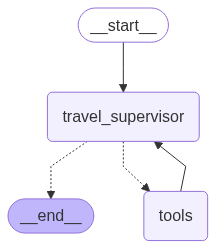

In [22]:
from IPython.display import Image, display
display(Image(travel_planner.get_graph().draw_mermaid_png()))

In [23]:
input = "Hi, I’m planning a 10-day trip to Rajasthan next month with a hotel budget of around $50 per night. Could you help me with the weather forecast, must-visit attractions, and an estimated total cost of the trip? I’ll be paying in INR, but my home currency is USD. I prefer local cuisine and public transport. Can you plan everything for me?"
recommended_plan=travel_planner.invoke({"messages": [input]})

for m in recommended_plan["messages"]:
    m.pretty_print()

##travel_supervisor## [HumanMessage(content='Hi, I’m planning a 10-day trip to Rajasthan next month with a hotel budget of around $50 per night. Could you help me with the weather forecast, must-visit attractions, and an estimated total cost of the trip? I’ll be paying in INR, but my home currency is USD. I prefer local cuisine and public transport. Can you plan everything for me?', additional_kwargs={}, response_metadata={}, id='f567bd04-b7f1-40d6-958f-0ff367b7d2cb')]
##travel_supervisor## [HumanMessage(content='Hi, I’m planning a 10-day trip to Rajasthan next month with a hotel budget of around $50 per night. Could you help me with the weather forecast, must-visit attractions, and an estimated total cost of the trip? I’ll be paying in INR, but my home currency is USD. I prefer local cuisine and public transport. Can you plan everything for me?', additional_kwargs={}, response_metadata={}, id='f567bd04-b7f1-40d6-958f-0ff367b7d2cb'), AIMessage(content='', additional_kwargs={'tool_calls

In [24]:
from IPython.display import Markdown
Markdown(recommended_plan["messages"][-1].content)

Here's a comprehensive plan for your 10-day trip to Rajasthan:

### Top Attractions:
1. **Jaipur**: Explore the Pink City with its iconic Amber Fort, City Palace, and Hawa Mahal.
2. **Udaipur**: Visit the City Palace and enjoy a boat ride on Lake Pichola.
3. **Jaisalmer**: Discover the Jaisalmer Fort and enjoy a camel safari in the Thar Desert.
4. **Jodhpur**: Explore the Mehrangarh Fort and the blue streets of the old city.
5. **Pushkar**: Visit the sacred Pushkar Lake and the Brahma Temple.

### Activities:
- Camel safaris in the Thar Desert.
- Hot air ballooning in Jaipur.
- Zip-lining at Mehrangarh Fort.
- Cultural shows and folk dances.

### Restaurants:
- **Suvarna Mahal** at Rambagh Palace, Jaipur.
- Local street food tours in Jaipur and Jodhpur.
- Authentic Rajasthani thali at local eateries.

### Transportation:
- Public buses and trains are well-connected across Rajasthan.
- Auto-rickshaws and taxis for local travel.

### Weather:
- Current: Partly Cloudy, 27°C.
- Forecast: Expect warm days with temperatures ranging from 25°C to 35°C.

### Currency Conversion:
- 1 USD = 86.80 INR

### Hotel Expense:
- $50 per night for 10 nights = $500
- In INR: 500 * 86.80 = ₹43,400

### Itinerary:
- **Day 1-2**: Jaipur - Explore forts and palaces.
- **Day 3-4**: Udaipur - Enjoy lakes and palaces.
- **Day 5-6**: Jaisalmer - Desert safari and fort visit.
- **Day 7-8**: Jodhpur - Forts and local markets.
- **Day 9-10**: Pushkar - Temples and local culture.

### Total Approximate Expense:
- Hotel: ₹43,400
- Food, transport, and activities: Approx. ₹30,000
- Total: ₹73,400 (Approx. $845)

Enjoy your cultural and adventurous journey through Rajasthan!

In [25]:
input = "Hi, I’m planning a 5-day trip to Varanasi next month with a hotel budget of around ₹3000 per night. Could you help me with the expected weather, key places to visit, and an estimated total trip cost? I’ll be paying in Indian Rupees, but my native currency is USD. I prefer local food and public transport. Can you plan the entire trip for me?"
recommended_plan = travel_planner.invoke({"messages": [input]})

for m in recommended_plan["messages"]:
    m.pretty_print()
    

##travel_supervisor## [HumanMessage(content='Hi, I’m planning a 5-day trip to Varanasi next month with a hotel budget of around ₹3000 per night. Could you help me with the expected weather, key places to visit, and an estimated total trip cost? I’ll be paying in Indian Rupees, but my native currency is USD. I prefer local food and public transport. Can you plan the entire trip for me?', additional_kwargs={}, response_metadata={}, id='7910b25e-aeb5-46c9-a6cb-5ccf912a9eee')]
##travel_supervisor## [HumanMessage(content='Hi, I’m planning a 5-day trip to Varanasi next month with a hotel budget of around ₹3000 per night. Could you help me with the expected weather, key places to visit, and an estimated total trip cost? I’ll be paying in Indian Rupees, but my native currency is USD. I prefer local food and public transport. Can you plan the entire trip for me?', additional_kwargs={}, response_metadata={}, id='7910b25e-aeb5-46c9-a6cb-5ccf912a9eee'), AIMessage(content='', additional_kwargs={'to

In [26]:
from IPython.display import Markdown
Markdown(recommended_plan["messages"][-1].content)

Here's a detailed plan for your 5-day trip to Varanasi:

### Top Attractions:
1. **Dasaswamedh Ghat**: A vibrant area perfect for people-watching and experiencing the Ganga Aarti.
2. **Ramnagar Fort**: Explore the historical fort and its museum.
3. **Sarnath**: Visit the site where Buddha gave his first sermon.
4. **Kashi Vishwanath Temple**: A sacred Hindu temple dedicated to Lord Shiva.

### Activities:
- **Boat Ride on the Ganges**: Experience the spiritual aura of Varanasi.
- **Shopping**: Explore local markets for Banarasi sarees and handicrafts.
- **Attend a Local Festival**: Immerse yourself in the local culture.

### Restaurants:
- **Canton Royale**: Offers a variety of cuisines.
- **Brown Bread Bakery**: Known for its organic food.
- **Varuna & Chowk at Taj Ganges**: Try local delicacies.

### Transportation:
- **Auto-rickshaws**: Convenient for short distances.
- **Bicycles and E-bikes**: Eco-friendly options.
- **Public Buses**: Economical for longer distances.

### Weather:
- **Current**: 29°C with patchy rain nearby.
- **Forecast**: Expect thunderstorms with temperatures ranging from 26°C to 32°C.

### Hotel and Expenses:
- **Hotel Budget**: ₹3000 per night, totaling ₹15,000 for 5 nights.
- **Converted to USD**: Approximately $260.41.

### Itinerary:
- **Day 1**: Arrival, explore Dasaswamedh Ghat, and enjoy a boat ride.
- **Day 2**: Visit Sarnath and Ramnagar Fort.
- **Day 3**: Explore local markets and attend a local festival.
- **Day 4**: Visit Kashi Vishwanath Temple and enjoy local cuisine.
- **Day 5**: Leisure day, explore more ghats or relax.

### Total Approximate Expense:
- **Hotel**: ₹15,000
- **Food and Activities**: ₹5,000
- **Transportation**: ₹2,000
- **Total**: ₹22,000 (Approx. $382.50 USD)

Enjoy your spiritual and cultural journey in Varanasi!